## install pysgmcmc

In [ ]:
!pip install git+https://github.com/MFreidank/pysgmcmc
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MFreidank/pysgmcmc to /tmp/pip-req-build-zxherv5e
  Running command git clone --filter=blob:none --quiet https://github.com/MFreidank/pysgmcmc /tmp/pip-req-build-zxherv5e
  Resolved https://github.com/MFreidank/pysgmcmc to commit 1fe63570486e2d3f6cc2d3016314a92b96464b00
  Preparing metadata (setup.py) ... done


## import and data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [76]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# code retrieved from https://pysgmcmc.readthedocs.io/en/pytorch/_modules/pysgmcmc/optimizers/sgld.html

import torch
from torch.optim import Optimizer


# Pytorch Port of a previous tensorflow implementation in `tensorflow_probability`:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/g3doc/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics.md
class SGLD(Optimizer):
    """ Stochastic Gradient Langevin Dynamics Sampler with preconditioning.
        Optimization variable is viewed as a posterior sample under Stochastic
        Gradient Langevin Dynamics with noise rescaled in eaach dimension
        according to RMSProp.
    """
    def __init__(self,
                 params,
                 lr=1e-2,
                 precondition_decay_rate=0.95,
                 num_pseudo_batches=1,
                 num_burn_in_steps=3000,
                 diagonal_bias=1e-8) -> None:
        """ Set up a SGLD Optimizer.

        Parameters
        ----------
        params : iterable
            Parameters serving as optimization variable.
        lr : float, optional
            Base learning rate for this optimizer.
            Must be tuned to the specific function being minimized.
            Default: `1e-2`.
        precondition_decay_rate : float, optional
            Exponential decay rate of the rescaling of the preconditioner (RMSprop).
            Should be smaller than but nearly `1` to approximate sampling from the posterior.
            Default: `0.95`
        num_pseudo_batches : int, optional
            Effective number of minibatches in the data set.
            Trades off noise and prior with the SGD likelihood term.
            Note: Assumes loss is taken as mean over a minibatch.
            Otherwise, if the sum was taken, divide this number by the batch size.
            Default: `1`.
        num_burn_in_steps : int, optional
            Number of iterations to collect gradient statistics to update the
            preconditioner before starting to draw noisy samples.
            Default: `3000`.
        diagonal_bias : float, optional
            Term added to the diagonal of the preconditioner to prevent it from
            degenerating.
            Default: `1e-8`.

        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(num_burn_in_steps))

        defaults = dict(
            lr=lr, precondition_decay_rate=precondition_decay_rate,
            num_pseudo_batches=num_pseudo_batches,
            num_burn_in_steps=num_burn_in_steps,
            diagonal_bias=1e-8,
        )
        super().__init__(params, defaults)


    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for parameter in group["params"]:

                if parameter.grad is None:
                    continue

                state = self.state[parameter]
                lr = group["lr"]
                num_pseudo_batches = group["num_pseudo_batches"]
                precondition_decay_rate = group["precondition_decay_rate"]
                gradient = parameter.grad.data

                #  State initialization {{{ #

                if len(state) == 0:
                    state["iteration"] = 0
                    state["momentum"] = torch.ones_like(parameter)

                #  }}} State initialization #

                state["iteration"] += 1

                momentum = state["momentum"]

                #  Momentum update {{{ #
                momentum.add_(
                    (1.0 - precondition_decay_rate) * ((gradient ** 2) - momentum)
                )
                #  }}} Momentum update #

                if state["iteration"] > group["num_burn_in_steps"]:
                    sigma = 1. / torch.sqrt(torch.tensor(lr))
                else:
                    sigma = torch.zeros_like(parameter)

                preconditioner = (
                    1. / torch.sqrt(momentum + group["diagonal_bias"])
                )

                scaled_grad = (
                    0.5 * preconditioner * gradient * num_pseudo_batches +
                    torch.normal(
                        mean=torch.zeros_like(gradient),
                        std=torch.ones_like(gradient)
                    ) * sigma * torch.sqrt(preconditioner)
                )

                parameter.data.add_(-lr * scaled_grad)

        return loss

## base model: ResNet

In [9]:
# https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [10]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def partial_eval(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [24]:
net = ResNet18()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [25]:
#import pysgmcmc

In [26]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = SGLD(net.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [27]:

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images:'+str(correct / total))
    #scheduler.step()
print('Finished Training')


[1,  1563] loss: 1.331
Accuracy of the network on the test images:0.6718
[2,  1563] loss: 0.784
Accuracy of the network on the test images:0.7628
[3,  1563] loss: 0.589
Accuracy of the network on the test images:0.7914
[4,  1563] loss: 0.474
Accuracy of the network on the test images:0.8048
[5,  1563] loss: 0.382
Accuracy of the network on the test images:0.8132
[6,  1563] loss: 0.308
Accuracy of the network on the test images:0.8172
[7,  1563] loss: 0.252
Accuracy of the network on the test images:0.8182
[8,  1563] loss: 0.200
Accuracy of the network on the test images:0.8146
[9,  1563] loss: 0.169
Accuracy of the network on the test images:0.8199
[10,  1563] loss: 0.135
Accuracy of the network on the test images:0.8298
[11,  1563] loss: 0.122
Accuracy of the network on the test images:0.8217
[12,  1563] loss: 0.110
Accuracy of the network on the test images:0.8224
[13,  1563] loss: 0.096
Accuracy of the network on the test images:0.8145
[14,  1563] loss: 0.095
Accuracy of the network

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Res18.pth ./Res18.pth
PATH = './Res18_v2.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18().to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

Mounted at /content/drive


<All keys matched successfully>

In [29]:
PATH = './Res18_v2.pth'
#projection_weight_path = './LeNet_pr.pth'
torch.save(net.state_dict(), PATH)
#torch.save(net.projection, projection_weight_path)

In [31]:
PATH = './Res18_v2.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18().to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

<All keys matched successfully>

In [77]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.8301


In [32]:

from google.colab import drive
drive.mount('/content/drive')
!cp ./Res18_v2.pth /content/drive/MyDrive/Res18_v2.pth


Mounted at /content/drive


## NN decryption 3 party (flexible)


In [33]:
x_t = next(iter(testloader))
x_t = x_t[0].to(device)
r = net.partial_eval(x_t)
print(r.shape)

torch.Size([32, 64, 32, 32])


In [34]:
print(x_t.shape)

torch.Size([32, 3, 32, 32])


In [42]:
import copy

In [69]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_decrypt(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_decrypt, self).__init__()
        self.in_planes = 64

        self.enc1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.enc2 = nn.BatchNorm2d(64)
        self.enc_layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.enc2(self.enc1(x)))
        out = self.enc_layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def partial_eval(self, x):
        out = F.relu(self.enc2(self.enc1(x)))
        out = self.enc_layer1(out)
        return out


def ResNet18_dec():
    return ResNet_decrypt(BasicBlock, [2, 2, 2, 2])


def ResNet34_dec():
    return ResNet_decrypt(BasicBlock, [3, 4, 6, 3])


def ResNet50_dec():
    return ResNet_decrypt(Bottleneck, [3, 4, 6, 3])


def ResNet101_dec():
    return ResNet_decrypt(Bottleneck, [3, 4, 23, 3])


def ResNet152_dec():
    return ResNet_decrypt(Bottleneck, [3, 8, 36, 3])


def test_dec():
    net = ResNet18_dec()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

def construct_decrypt_net(k):
    net_decrypt = ResNet18_dec()

    # freeze anything after layer1
    net_decrypt.layer2.requires_grad_(False)
    net_decrypt.layer3.requires_grad_(False)
    net_decrypt.layer4.requires_grad_(False)
    net_decrypt.linear.requires_grad_(False)

    # unfreeze last k layers
    counter = 0
    for name, param in net_decrypt.named_parameters():
        counter+=1

    #counter/=2
    c = 0

    state_dict_ = copy.deepcopy(net.state_dict())
    #print(len(state_dict_.keys()))
    #print(state_dict_.keys()[0])
    for name, param in net_decrypt.named_parameters():
        #bias and weight
        if k==0:
          pass
        elif c>=counter-int(k*1.5+1):
            param.requires_grad = True
            state_dict_.pop(name)
        c+=1
    #print(len(state_dict_.keys()))
    net_decrypt.to(device)

    #PATH = './Res18.pth'
    net_decrypt.load_state_dict(state_dict_, strict=False)
    return net_decrypt


train the top layers

In [78]:

cosine_similarity = []
mse_ = []
test_acc= []
#cosine_similarity = cosine_similarity
#mse_ = mse_
for iteration in range(20):
    net_decrypt = construct_decrypt_net(iteration)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net_decrypt.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(30):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_decrypt(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            '''
            if i % 1000 == 999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
                running_loss = 0.0
            '''
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
        running_loss = 0.0
        correct = 0
        total = 0

    print('Finished Training')

    corr = []
    MSE_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    cos = torch.nn.CosineSimilarity(dim=0).to(device)
    mse_metric = nn.MSELoss().to(device)

    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            '''
            # calculate outputs by running images through the network
            intermediate = net.partial_eval(images)
            print(intermediate.shape)
            sh = images[0,:,:,:].cpu().numpy()
            sh = sh/2+0.5
            plt.imshow(np.transpose(sh, (1,2,0)))
            plt.show()
            plt.imshow(intermediate[0,1,:,:].cpu().numpy())
            break
            outputs = net_decrypt.partial_out(intermediate)
            '''

            # calculate outputs by running images through the network
            outputs = net_decrypt(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            ori_inter = net.partial_eval(images)
            decrypt_inter = net_decrypt.partial_eval(images)
            corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
            MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())


        cosine_similarity.append((sum(corr)/len(corr)).cpu().numpy())
        print("cosine similarity for split at "+str(iteration)+": "+str(cosine_similarity[-1]))
        mse_.append((sum(MSE_loss)/len(corr)))
        test_acc.append(correct/total)
        print("test accuracy for split at "+str(iteration)+": "+str(test_acc[-1]))



Finished Training
cosine similarity for split at 0: 0.7271675
test accuracy for split at 0: 0.8427
Finished Training
cosine similarity for split at 1: 0.7489721
test accuracy for split at 1: 0.8401
Finished Training
cosine similarity for split at 2: 0.77731943
test accuracy for split at 2: 0.8404
Finished Training
cosine similarity for split at 3: 0.80481464
test accuracy for split at 3: 0.8442
Finished Training
cosine similarity for split at 4: 0.7955231
test accuracy for split at 4: 0.8476
Finished Training
cosine similarity for split at 5: 0.82179105
test accuracy for split at 5: 0.8449
Finished Training
cosine similarity for split at 6: 0.8222437
test accuracy for split at 6: 0.8341
Finished Training
cosine similarity for split at 7: 0.77624387
test accuracy for split at 7: 0.8377
Finished Training
cosine similarity for split at 8: 0.80970955
test accuracy for split at 8: 0.846
Finished Training
cosine similarity for split at 9: 0.8227098
test accuracy for split at 9: 0.8419
Finish

KeyboardInterrupt: ignored

In [79]:
print(mse_)
print(cosine_similarity)
print(test_acc)

[1.3757064555780576, 1.2174986303804782, 1.3829171276701906, 1.4613700945156451, 1.451703663070362, 1.5190820728247159, 1.5603145802744662, 1.445120233316391, 1.5245656990014707, 1.6183720293898172, 1.5911245951637292, 1.583609141861669]
[array(0.7271675, dtype=float32), array(0.7489721, dtype=float32), array(0.77731943, dtype=float32), array(0.80481464, dtype=float32), array(0.7955231, dtype=float32), array(0.82179105, dtype=float32), array(0.8222437, dtype=float32), array(0.77624387, dtype=float32), array(0.80970955, dtype=float32), array(0.8227098, dtype=float32), array(0.81974787, dtype=float32), array(0.82414687, dtype=float32)]
[0.8427, 0.8401, 0.8404, 0.8442, 0.8476, 0.8449, 0.8341, 0.8377, 0.846, 0.8419, 0.84, 0.8411]


In [80]:
#net_decrypt = construct_decrypt_net(0)

for name, param in net_decrypt.named_parameters():
    print(name+'\t\t\t'+str(param.requires_grad))


enc1.weight			True
enc2.weight			True
enc2.bias			True
enc_layer1.0.conv1.weight			True
enc_layer1.0.bn1.weight			True
enc_layer1.0.bn1.bias			True
enc_layer1.0.conv2.weight			True
enc_layer1.0.bn2.weight			True
enc_layer1.0.bn2.bias			True
enc_layer1.1.conv1.weight			True
enc_layer1.1.bn1.weight			True
enc_layer1.1.bn1.bias			True
enc_layer1.1.conv2.weight			True
enc_layer1.1.bn2.weight			True
enc_layer1.1.bn2.bias			True
layer2.0.conv1.weight			False
layer2.0.bn1.weight			False
layer2.0.bn1.bias			False
layer2.0.conv2.weight			False
layer2.0.bn2.weight			False
layer2.0.bn2.bias			False
layer2.0.shortcut.0.weight			False
layer2.0.shortcut.1.weight			False
layer2.0.shortcut.1.bias			False
layer2.1.conv1.weight			False
layer2.1.bn1.weight			False
layer2.1.bn1.bias			False
layer2.1.conv2.weight			False
layer2.1.bn2.weight			False
layer2.1.bn2.bias			False
layer3.0.conv1.weight			False
layer3.0.bn1.weight			False
layer3.0.bn1.bias			False
layer3.0.conv2.weight			False
layer3.0.bn2.weight	

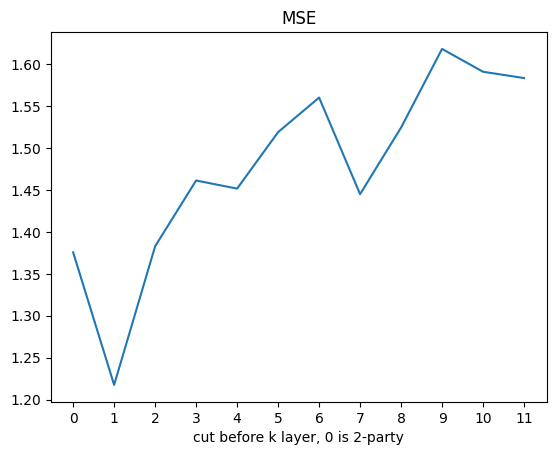

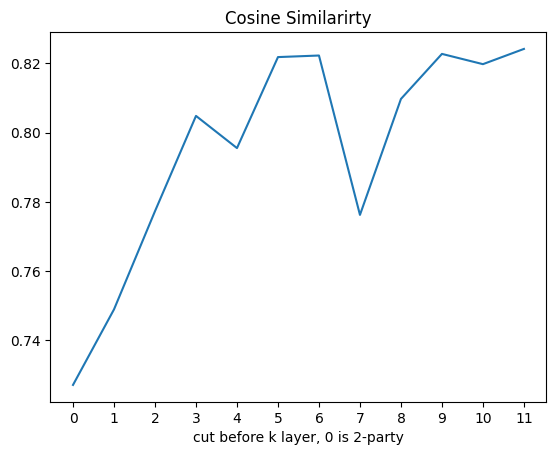

In [81]:
x = [i for i in range(len(mse_))]
xi = [i for i in range(len(mse_))]
plt.plot(x, mse_)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title('MSE')
plt.show()
plt.plot(x, cosine_similarity)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("Cosine Similarirty")
plt.show()

In [82]:
# test cosine similarity for initialization
cosine_similarity = []
mse_ = []
test_acc= []
#cosine_similarity = cosine_similarity
#mse_ = mse_
for iteration in range(20):
    net_decrypt = construct_decrypt_net(iteration)

    corr = []
    MSE_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    cos = torch.nn.CosineSimilarity(dim=0).to(device)
    mse_metric = nn.MSELoss().to(device)

    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            '''
            # calculate outputs by running images through the network
            intermediate = net.partial_eval(images)
            print(intermediate.shape)
            sh = images[0,:,:,:].cpu().numpy()
            sh = sh/2+0.5
            plt.imshow(np.transpose(sh, (1,2,0)))
            plt.show()
            plt.imshow(intermediate[0,1,:,:].cpu().numpy())
            break
            outputs = net_decrypt.partial_out(intermediate)
            '''

            # calculate outputs by running images through the network
            outputs = net_decrypt(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            ori_inter = net.partial_eval(images)
            decrypt_inter = net_decrypt.partial_eval(images)
            corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
            MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())


        cosine_similarity.append((sum(corr)/len(corr)).cpu().numpy())
        print("cosine similarity for split at "+str(iteration)+": "+str(cosine_similarity[-1]))
        mse_.append((sum(MSE_loss)/len(corr)))
        test_acc.append(correct/total)
        print("test accuracy for split at "+str(iteration)+": "+str(test_acc[-1]))

cosine similarity for split at 0: 0.3707772
test accuracy for split at 0: 0.1688
cosine similarity for split at 1: 0.38429928
test accuracy for split at 1: 0.0805
cosine similarity for split at 2: 0.37930742
test accuracy for split at 2: 0.1165
cosine similarity for split at 3: 0.3821619
test accuracy for split at 3: 0.1151
cosine similarity for split at 4: 0.37715706
test accuracy for split at 4: 0.1016
cosine similarity for split at 5: 0.36769122
test accuracy for split at 5: 0.1036
cosine similarity for split at 6: 0.37807548
test accuracy for split at 6: 0.1003
cosine similarity for split at 7: 0.37103155
test accuracy for split at 7: 0.0651
cosine similarity for split at 8: 0.36308458
test accuracy for split at 8: 0.0995
cosine similarity for split at 9: 0.3712679
test accuracy for split at 9: 0.0775
cosine similarity for split at 10: 0.36660957
test accuracy for split at 10: 0.1036
cosine similarity for split at 11: 0.38123107
test accuracy for split at 11: 0.0996
cosine similari

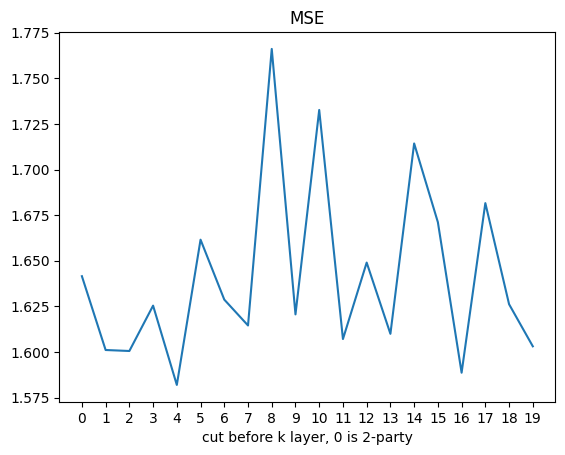

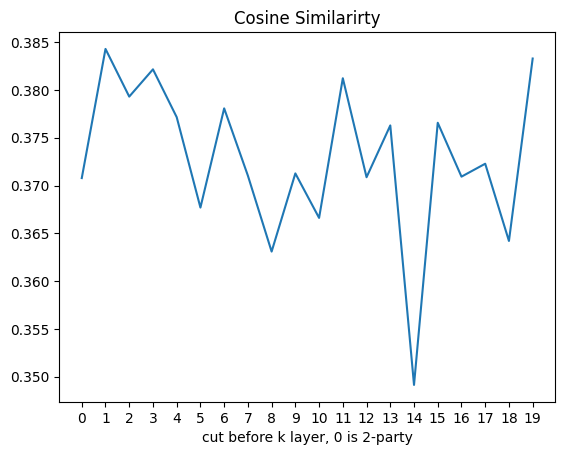

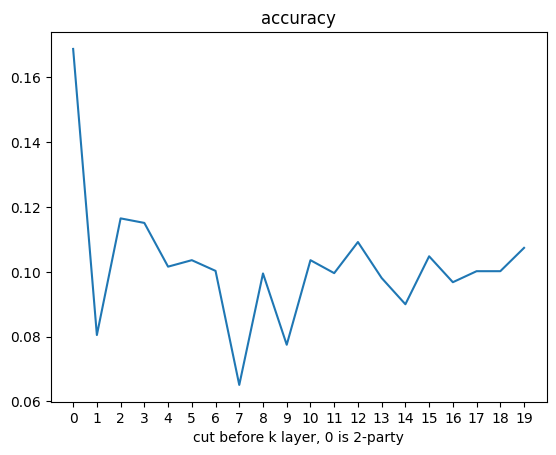

In [83]:
#untrained initialization
x = [i for i in range(len(mse_))]
xi = [i for i in range(len(mse_))]
plt.plot(x, mse_)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title('MSE')
plt.show()
plt.plot(x, cosine_similarity)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("Cosine Similarirty")
plt.show()
plt.plot(x, test_acc)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("accuracy")
plt.show()

In [ ]:

#cosine_similarity = cosine_similarity
#mse_ = mse_

net_decrypt = construct_decrypt_net(0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_decrypt.parameters(), lr=0.01, momentum=0.9)
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decrypt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
    correct = 0
    total = 0

print('Finished Training')

corr = []
MSE_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
cos = torch.nn.CosineSimilarity(dim=0).to(device)
mse_metric = nn.MSELoss().to(device)

correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''

        # calculate outputs by running images through the network
        outputs = net_decrypt(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        ori_inter = net.partial_eval(images)
        decrypt_inter = net_decrypt.partial_eval(images)
        corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
        MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())





In [ ]:
#PATH = './ResNet_decrypt_3.pth'
PATH = './ResNet_decrypt_v2.pth'

torch.save(net_decrypt.state_dict(), PATH)

In [ ]:
PATH = './ResNet_decrypt_v2.pth'

net_decrypt.load_state_dict(torch.load(PATH))

In [ ]:
PATH2 = './Res18_v2.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18(img_channels=3, num_classes=10).to(device)
net.load_state_dict(torch.load(PATH2))

In [91]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        outputs = net_decrypt(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.8427


In [ ]:

#!cp ./ResNet_decrypt_3.pth /content/drive/MyDrive/ResNet_decrypt_3.pth

!cp ./ResNet_decrypt_v2.pth /content/drive/MyDrive/ResNet_decrypt_v2.pth

what we know: bad performance when using CNN to simulate 1 layer of ResNet -> unknown architecture could cause significant defifference

on the other hand, if we know the architecture, we can somewhat recover the weights and use decoder to recover the image

conclusion1 of now: there exists "SOME" encoder-decoder group that can recover the image if the server knows the training dataset

conclusion2 of now: model similarity is inverse propotional to the computation on the client side: more computation on the client side -> less similar the intermediate image is.

when server only computes layer 2 and 3, cosine similarity is 0.4, whereas when server computes layer 2-4, cosine similarity is 0.86.

As of now, decoder designed based on encoder (transpose conv) does not generate accurate decoding image.

TODO:
1. is there a p-tolerant decoder that recovers images with at least p cosine similarity?
2. try client-server split at each layer and measure the cosine similarity of intermediate latent feature -> expect to see a decay
3. is there a boundary on how good a decoder can be?


### decoder

In [131]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_decoder(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_decoder, self).__init__()
        self.in_planes = 64

        self.enc1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.enc2 = nn.BatchNorm2d(64)
        self.enc_layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        '''
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        '''
        self.dec_layer1=self._make_layer(block, 64, num_blocks[0], stride=1)
        #self.dec2 = nn.BatchNorm2d(64)
        self.dec1 = nn.Conv2d(64, 3, kernel_size=3,
                               stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.enc2(self.enc1(x)))
        out = self.enc_layer1(out)
        '''
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        '''
        out = self.dec_layer1(out)
        #out = F.relu(self.dec1(self.dec2(x)))
        out = self.dec1(out)
        return out

    def partial_eval(self, x):
        out = self.dec_layer1(x)
        #out = F.relu(self.dec1(self.dec2(x)))
        out = self.dec1(out)
        return out


def ResNet18_decoder():
    return ResNet_decoder(BasicBlock, [2, 2, 2, 2])


def ResNet34_decoder():
    return ResNet_decoder(BasicBlock, [3, 4, 6, 3])

net_decoder = ResNet18_decoder()
net_decoder.to(device)



ResNet_decoder(
  (enc1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=

In [132]:
'''
PATH = './LeNet_decrypt.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)
'''

# freeze anything before decoder
net_decoder.enc1.requires_grad_(False)
net_decoder.enc2.requires_grad_(False)
net_decoder.enc_layer1.requires_grad_(False)


Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
)

In [133]:
for param in net_decoder.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True


In [134]:
PATH = './ResNet_decrypt_v2.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)

_IncompatibleKeys(missing_keys=['dec_layer1.0.conv1.weight', 'dec_layer1.0.bn1.weight', 'dec_layer1.0.bn1.bias', 'dec_layer1.0.bn1.running_mean', 'dec_layer1.0.bn1.running_var', 'dec_layer1.0.conv2.weight', 'dec_layer1.0.bn2.weight', 'dec_layer1.0.bn2.bias', 'dec_layer1.0.bn2.running_mean', 'dec_layer1.0.bn2.running_var', 'dec_layer1.1.conv1.weight', 'dec_layer1.1.bn1.weight', 'dec_layer1.1.bn1.bias', 'dec_layer1.1.bn1.running_mean', 'dec_layer1.1.bn1.running_var', 'dec_layer1.1.conv2.weight', 'dec_layer1.1.bn2.weight', 'dec_layer1.1.bn2.bias', 'dec_layer1.1.bn2.running_mean', 'dec_layer1.1.bn2.running_var', 'dec1.weight'], unexpected_keys=['layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.bn2.num_batches_tracked', 'layer2.0.shortcut.0.weight

In [135]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)

In [136]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decoder(inputs)
        #outputs = net.partial_eval(inputs)
        #outputs = net_decoder(outputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
print('Finished Training')

[1,  1563] loss: 0.133
[2,  1563] loss: 0.078
[3,  1563] loss: 0.066
[4,  1563] loss: 0.063
[5,  1563] loss: 0.053
[6,  1563] loss: 0.050
[7,  1563] loss: 0.047
[8,  1563] loss: 0.045
[9,  1563] loss: 0.041
[10,  1563] loss: 0.038
[11,  1563] loss: 0.036
[12,  1563] loss: 0.035
[13,  1563] loss: 0.035


KeyboardInterrupt: ignored

In [137]:
img_compare = trainset[0][0].cuda()

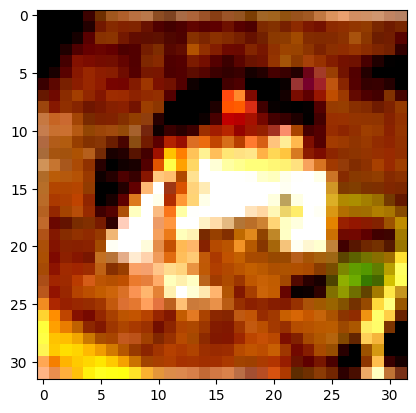

In [138]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img_compare.detach().cpu())

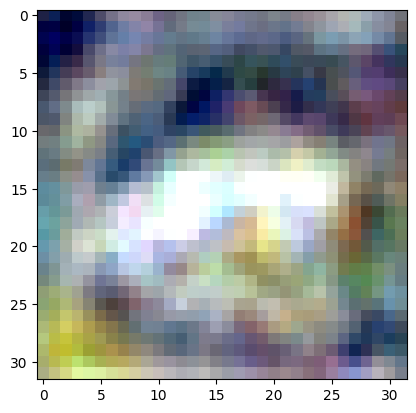

In [139]:
target = img_compare[None,:,:,:]
result = net_decoder.partial_eval((net.partial_eval(target)))
imshow(result[0].detach().cpu())

compare weights between two models

In [ ]:
weight_diff = [(x - y).abs().sum() for x, y in zip(net.state_dict().values(), net_decrypt.state_dict().values())]

In [ ]:
net.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.conv3.bias', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.identity_downsample.0.weight', 'layer1.0.identity_downsample.0.bias', 'layer1.0.identity_downsample.1.weight', 'layer1.0.identity_downsample.1.bias', 'layer1.0.identity_downsample.1.running_mean', 'layer1.0.identity_downsample.1.running_var', 'layer1.0.identity_downsample.1.num_batches_tracked', 'lay

In [ ]:
net_values = []
for n,_ in net.named_parameters():
  net_values.append(net.state_dict()[n])
net_decrypt_values = []
for n,_ in net_decrypt.named_parameters():
  net_decrypt_values.append(net_decrypt.state_dict()[n])

In [ ]:
diff = [net_decrypt_values[i] - net_values[i] for i in range(len(net_values))]

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0).to(device)
i = 0
for n,_ in net_decrypt.named_parameters():
  output = cos(torch.flatten(net_values[i]), torch.flatten(net_decrypt_values[i]))
  print(n+'\t\t\t'+str(output.cpu().numpy()))
  i+=1

enc1.weight			0.0248543
enc1.bias			-0.040352307
enc2.weight			0.99136543
enc2.bias			0.269043
enc_layer1.0.conv1.weight			0.02394851
enc_layer1.0.conv1.bias			-0.07429153
enc_layer1.0.bn1.weight			1.0
enc_layer1.0.bn1.bias			0.0
enc_layer1.0.conv2.weight			0.0059722904
enc_layer1.0.conv2.bias			-0.056167904
enc_layer1.0.bn2.weight			0.99675333
enc_layer1.0.bn2.bias			0.31944263
enc_layer1.0.conv3.weight			-0.0016735625
enc_layer1.0.conv3.bias			0.0057369545
enc_layer1.0.bn3.weight			0.99490535
enc_layer1.0.bn3.bias			0.046297792
enc_layer1.0.identity_downsample.0.weight			-0.0018739784
enc_layer1.0.identity_downsample.0.bias			0.08620225
enc_layer1.0.identity_downsample.1.weight			0.99098605
enc_layer1.0.identity_downsample.1.bias			0.046297792
enc_layer1.1.conv1.weight			0.0049554654
enc_layer1.1.conv1.bias			0.029795337
enc_layer1.1.bn1.weight			1.0
enc_layer1.1.bn1.bias			0.0
enc_layer1.1.conv2.weight			0.002168947
enc_layer1.1.conv2.bias			-0.2096956
enc_layer1.1.bn2.weight			0.99

compare imtermediate images

In [ ]:
corr = []

# since we're not training, we don't need to calculate the gradients for our outputs
cos = torch.nn.CosineSimilarity(dim=0).to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        ori_inter = net.partial_eval(images)
        decrypt_inter = net_decrypt.partial_eval(images)
        corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))


print(corr[:10])

[tensor(0.4085, device='cuda:0'), tensor(0.4051, device='cuda:0'), tensor(0.4034, device='cuda:0'), tensor(0.4021, device='cuda:0'), tensor(0.4012, device='cuda:0'), tensor(0.4135, device='cuda:0'), tensor(0.3963, device='cuda:0'), tensor(0.3992, device='cuda:0'), tensor(0.4094, device='cuda:0'), tensor(0.4050, device='cuda:0')]


In [ ]:
sum(corr)/len(corr)

tensor(0.4066, device='cuda:0')

## store data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/LeNet.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_decrypt.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_pr.pth /content/drive/MyDrive/security_weight

### additional